# Анализ и предсказание продаж по компьютерным играм.
Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from scipy.stats import binom, norm
from math import sqrt

## Шаг 1. Работа с таблицей и поиск аномалий

In [2]:
data = pd.read_csv('/datasets/games.csv')
display(data.head())
data.info()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Много какие данные отсутствуют, больше всего это ощутимо в колонках с оценками и рейтингом

## Шаг 2. Подготовка данных

In [3]:
data.columns= data.columns.str.lower()

Так как tbd в колонке user_score обозначает to be determined, то есть еще не определено, для нашего анализа это равно значению NaN

In [4]:
data['user_score'] = data['user_score'].replace('tbd', float('NaN'))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
data['user_score'] = data['user_score'].replace('tbd', float('NaN'))
data.info()
data['user_score'] = pd.to_numeric(data['user_score'])
data['user_score'] = data['user_score'] * 10

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [6]:
data['total_sales'] = data[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis='columns')
data.head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,80.0,E,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,83.0,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,80.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN,30.26
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,85.0,E,29.80
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,66.0,E,28.91
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,84.0,E,28.32
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN,28.31


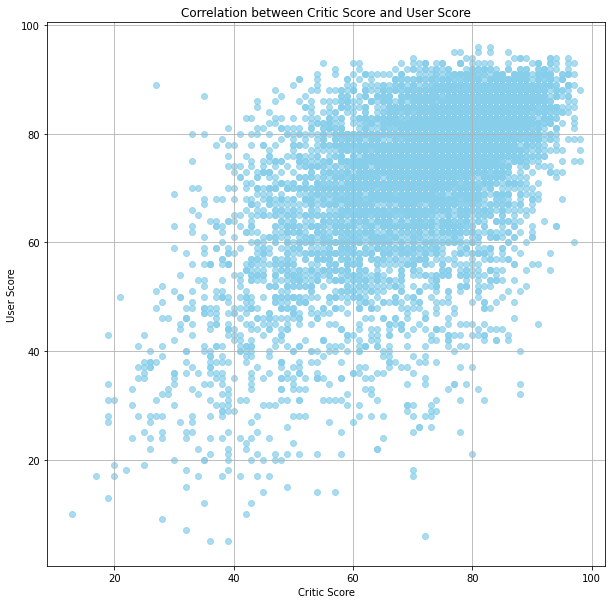

корреляция Пирсона между оценками критиков и продажами: 0.581
корреляция Кендалла между оценками пользователей и продажами: 0.388
корреляция Спирмана между оценками пользователей и продажами: 0.536


In [7]:
df = data[data['critic_score'].notna() & data['user_score'].notna()]
plt.figure(figsize=(10, 10))
plt.scatter(df['critic_score'], df['user_score'], color='skyblue', alpha=0.7)

plt.title('Correlation between Critic Score and User Score')
plt.xlabel('Critic Score')
plt.ylabel('User Score')

plt.grid(True)
plt.show()

pierson_correlation = round(df['critic_score'].corr(df['user_score']), 3)
kendall_correlation = round(st.kendalltau(df['user_score'], df['critic_score']).correlation, 3)
spearman_correlation = round(st.spearmanr(df['user_score'], df['critic_score']).correlation, 3)

print(f"корреляция Пирсона между оценками критиков и продажами: {pierson_correlation}")
print(f"корреляция Кендалла между оценками пользователей и продажами: {kendall_correlation}")
print(f"корреляция Спирмана между оценками пользователей и продажами: {spearman_correlation}")


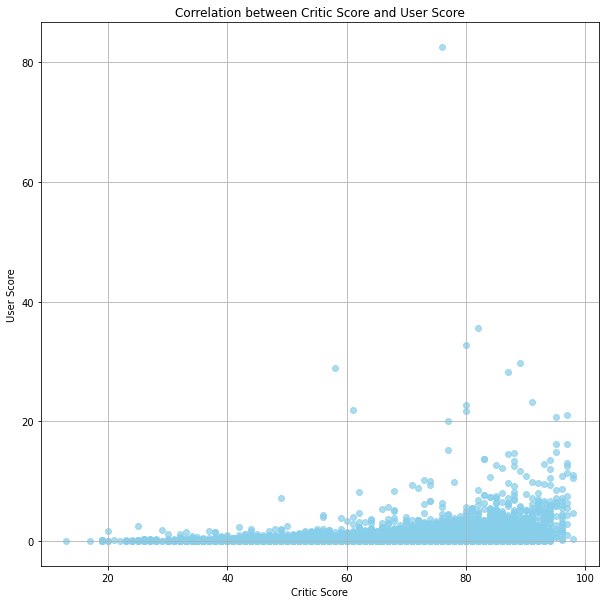

корреляция между оценками критиков и продажами: 0.246
корреляция между оценками пользователей и продажами: 0.275
корреляция между оценками пользователей и продажами: 0.394


In [8]:
df = data[data['critic_score'].notna() & data['total_sales'].notna()]
plt.figure(figsize=(10, 10))
plt.scatter(df['critic_score'], df['total_sales'], color='skyblue', alpha=0.7)

plt.title('Correlation between Critic Score and User Score')
plt.xlabel('Critic Score')
plt.ylabel('User Score')

plt.grid(True)
plt.show()

pierson_correlation = round(df['critic_score'].corr(df['total_sales']), 3)
kendall_correlation = round(st.kendalltau(df['critic_score'], df['total_sales']).correlation, 3)
spearman_correlation = round(st.spearmanr(df['critic_score'], df['total_sales']).correlation, 3)

print(f"корреляция между оценками критиков и продажами: {pierson_correlation}")
print(f"корреляция между оценками пользователей и продажами: {kendall_correlation}")
print(f"корреляция между оценками пользователей и продажами: {spearman_correlation}")

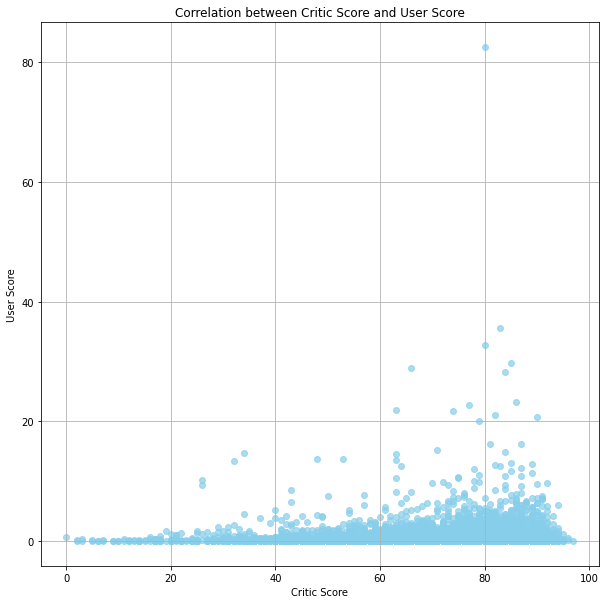

корреляция между оценками критиков и продажами: 0.088
корреляция между оценками пользователей и продажами: 0.103
корреляция между оценками пользователей и продажами: 0.15


In [9]:
df = data[data['user_score'].notna() & data['total_sales'].notna()]
plt.figure(figsize=(10, 10))
plt.scatter(df['user_score'], df['total_sales'], color='skyblue', alpha=0.7)

plt.title('Correlation between Critic Score and User Score')
plt.xlabel('Critic Score')
plt.ylabel('User Score')

plt.grid(True)
plt.show()

critic_correlation = round(df['user_score'].corr(df['total_sales']), 3)
user_correlation = round(st.kendalltau(df['user_score'], df['total_sales']).correlation, 3)
aaa_correlation = round(st.spearmanr(df['user_score'], df['total_sales']).correlation, 3)

print(f"корреляция между оценками критиков и продажами: {critic_correlation}")
print(f"корреляция между оценками пользователей и продажами: {user_correlation}")
print(f"корреляция между оценками пользователей и продажами: {aaa_correlation}")

Корреляция по каждому из признаков недостаточно высокая чтобы заполнять по их образу пропуски в оценках игр, поэтому оставлю их так  
К пропускам могли привести ошибки программы на любом этапе работы с данными  

Обработал типы данных, заменил значения tbd на NaN в колонке user_score, и привел вид оценки юзеров к виду критиков, оказалось что оценок юзеров еще меньше, чем критиков

Заполнил частично пропуски в оценках, в случаях, где неизвестна одна оценка, но известна другая, вполне вероятно, что они будут похожи, следовательно дополнил их друг другом  
Пропуски возможны из за сбоя программы, или же в случае tbd, оценка еще не определена  

In [11]:
b = data.duplicated().sum()
a = data[data.duplicated(subset=['name', 'platform'])]
a.head(10)
print('number of identical duplicates:', b)
a.head(10)

number of identical duplicates: 0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
1591,Need for Speed: Most Wanted,X360,2005.0,Racing,1.0,0.13,0.02,0.10,83.0,85.0,T,1.25
4127,Sonic the Hedgehog,PS3,NaN,Platform,0.0,0.48,0.00,0.00,43.0,41.0,E10+,0.48
11715,Need for Speed: Most Wanted,PC,2012.0,Racing,0.0,0.06,0.00,0.02,82.0,85.0,T,0.08
14244,NaN,GEN,1993.0,NaN,0.0,0.00,0.03,0.00,NaN,NaN,NaN,0.03
16230,Madden NFL 13,PS3,2012.0,Sports,0.0,0.01,0.00,0.00,83.0,55.0,E,0.01


странно, что одна и та же игра на одной и той же консоли выпускались несколько раз, в разные года, поэтому лучше удалить их

In [12]:
data = data.drop_duplicates(subset=['name', 'platform'])
a = data[data.duplicated(subset=['name', 'platform'])]
display(a.head(10))
data.info()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales


<class 'pandas.core.frame.DataFrame'>
Int64Index: 16710 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16709 non-null  object 
 1   platform         16710 non-null  object 
 2   year_of_release  16442 non-null  float64
 3   genre            16709 non-null  object 
 4   na_sales         16710 non-null  float64
 5   eu_sales         16710 non-null  float64
 6   jp_sales         16710 non-null  float64
 7   other_sales      16710 non-null  float64
 8   critic_score     8133 non-null   float64
 9   user_score       7586 non-null   float64
 10  rating           9945 non-null   object 
 11  total_sales      16710 non-null  float64
dtypes: float64(8), object(4)
memory usage: 1.7+ MB


### итоги предобработки данных  
Исправил название колонок под стандарт  
добавил колонку с суммарными продажами по миру  
привел к стандарту колонку user_score и преобразовал значения tbd в NaN  
удалил неявные дубликаты  

предобработка нужна для более точного анализа и удобной работы с данными

## Шаг 3. Исследовательский анализ данных

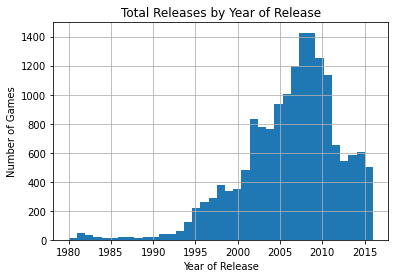

In [13]:
df = data.dropna(subset=['name'])
df['year_of_release'].hist(bins=37)
plt.xlabel('Year of Release')
plt.ylabel('Number of Games')
plt.title('Total Releases by Year of Release')
plt.show()

До 1995 года игр выпускалось совсем мало, имеет смысл взять данные с 1995 года

В 1995 году видимо технологии стали популярнее и доступнее, что вызвало бум количества выпущенных видеоигр, был стабильный рост, с пиком в 2007-2008 годах, после чего количество выпускаемых игр в год начало стабильно падать и на 2016 год имеет такое же количество как и в 2001

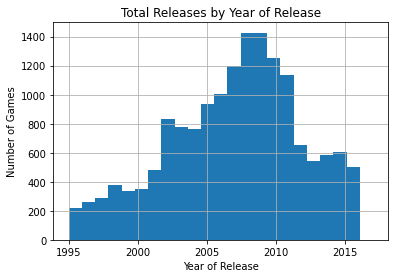

In [14]:
data['year_of_release'].hist(bins=23, range=(1995, 2017))
plt.xlabel('Year of Release')
plt.ylabel('Number of Games')
plt.title('Total Releases by Year of Release')
plt.show()

In [15]:
data = data[data['year_of_release'] > 1994]
data['year_of_release'].sort_values()

8503     1995.0
8223     1995.0
5629     1995.0
5623     1995.0
12791    1995.0
          ...  
12635    2016.0
12622    2016.0
16135    2016.0
12603    2016.0
16714    2016.0
Name: year_of_release, Length: 15955, dtype: float64

In [16]:
platform_sales = data.groupby('platform')['total_sales'].sum()

top_20_platforms = platform_sales.sort_values(ascending=False).head(22)
filtered_data = data[data['platform'].isin(top_20_platforms.index)]
platforms = filtered_data['platform'].unique()
years = filtered_data['year_of_release'].unique()

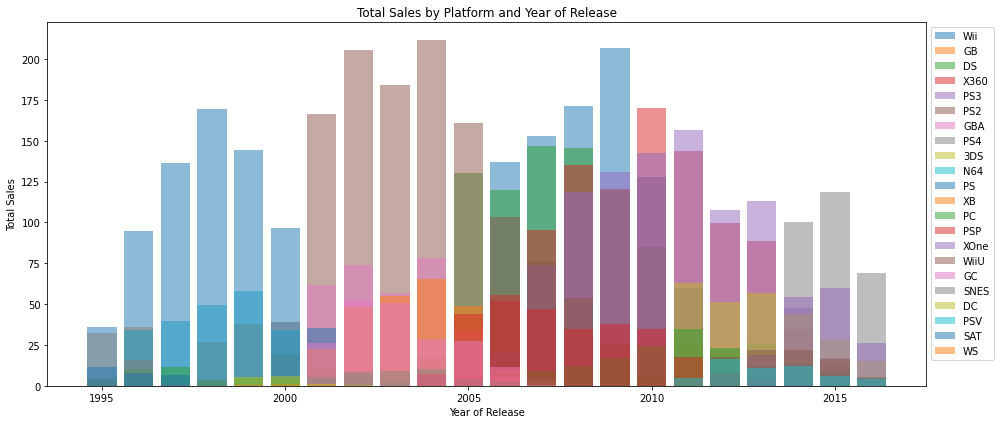

In [18]:
plt.figure(figsize=(14, 6))

for i, platform in enumerate(platforms):
    platform_data = data[data['platform'] == platform]
    sales = [platform_data[platform_data['year_of_release'] == year]['total_sales'].sum() for year in years]
    plt.bar(years, sales, label=platform, alpha=0.5)

plt.xlabel('Year of Release')
plt.ylabel('Total Sales')
plt.title('Total Sales by Platform and Year of Release')

plt.legend(bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

По графику видно, что большинство платформ остаются актуальны примерно 5 лет  

Рассмотрим последние 4 года поподробнее  

In [19]:
data = data.query('year_of_release > 2012')

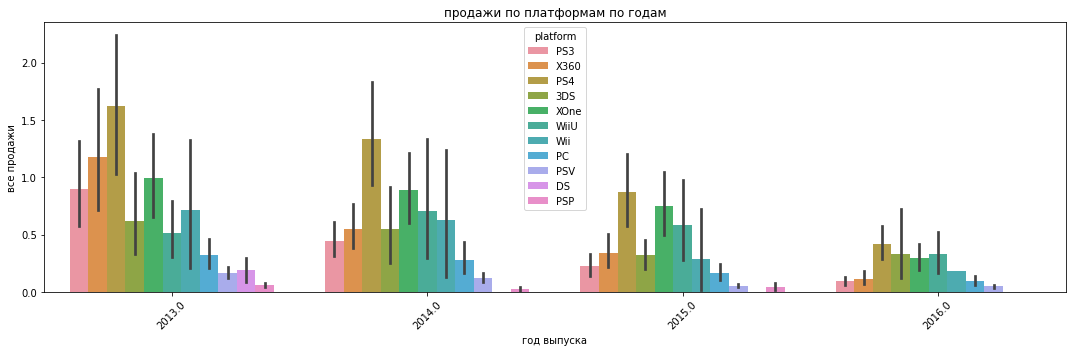

In [20]:
plt.figure(figsize=(15, 5))
sns.barplot(data=data, x='year_of_release', y='total_sales', hue='platform')

plt.xlabel('год выпуска')
plt.ylabel('все продажи')
plt.title('продажи по платформам по годам')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [21]:
platform_sales = data.groupby('platform')['total_sales'].sum()

top_10_platforms = platform_sales.sort_values(ascending=False).head(10)

display(platform_sales.sort_values(ascending=False))

platform
PS4     314.14
PS3     181.43
XOne    159.32
3DS     143.25
X360    136.80
WiiU     64.63
PC       39.43
PSV      32.99
Wii      13.66
PSP       3.50
DS        1.54
Name: total_sales, dtype: float64

Самыми потенциально прибыльными платформами на 2017 год являются: PS4, XOne, 3DS, WiiU остальные в списке выше хоть и имеют существенные продажи, но со уже находятся в стадии спада продаж, кроме разве что наверно PC, на компьютерах сложно предсказать продаваемость игр

<BarContainer object of 189 artists>

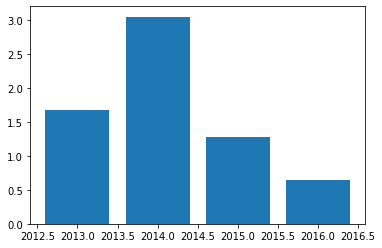

In [22]:
pc_games = data.query('platform == "PC"')
plt.bar(pc_games['year_of_release'], pc_games['total_sales'])

Игры на ПК повсему видимо остаются актуальны и зависят только от самих выпускаемых на них играх

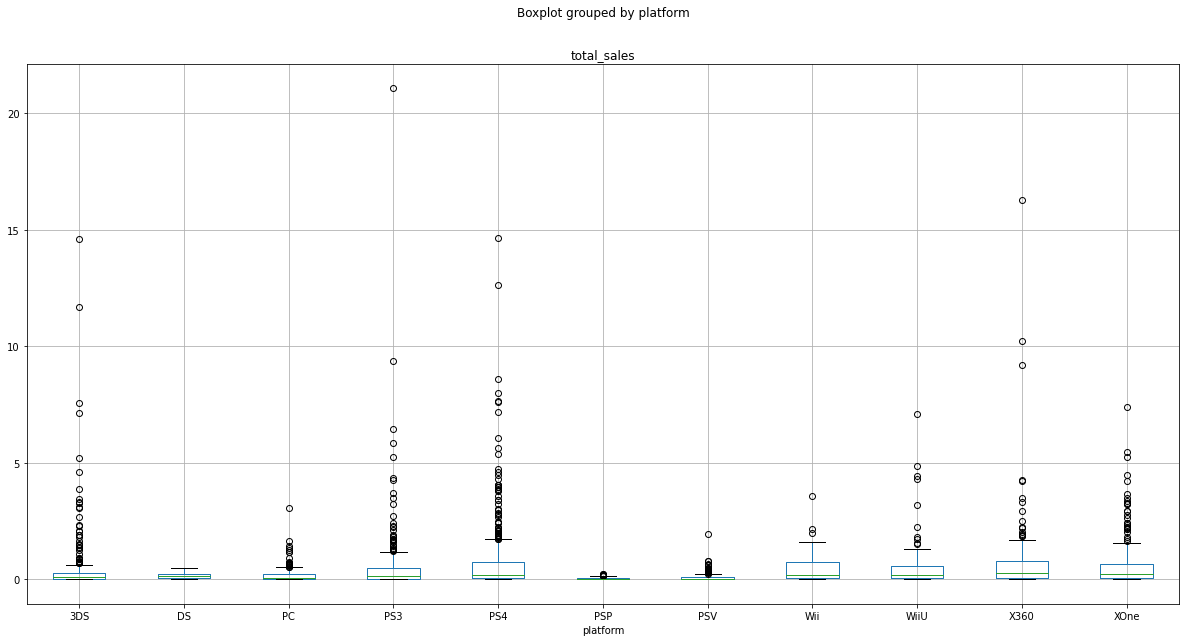

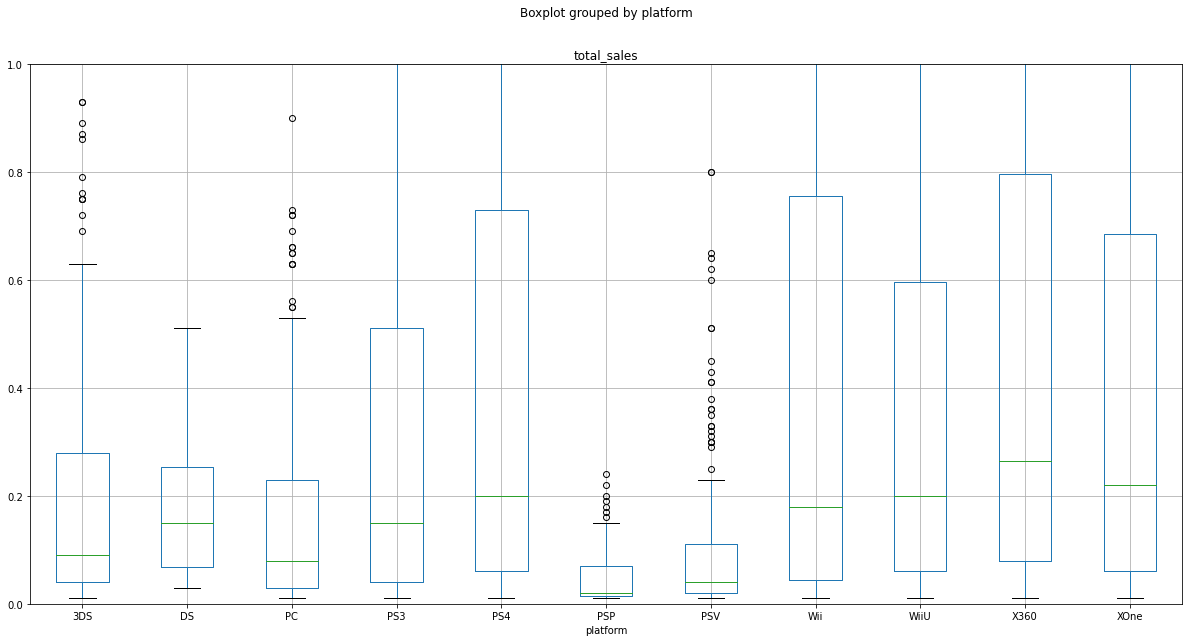

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,total_sales
count,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,991.000000,1192.000000,2233.000000
mean,2014.477385,0.196019,0.175652,0.063045,0.053726,72.023209,65.845638,0.488442
std,1.089439,0.547730,0.512451,0.233997,0.165693,12.841318,16.104132,1.235226
min,2013.000000,0.000000,0.000000,0.000000,0.000000,13.000000,2.000000,0.010000
25%,2014.000000,0.000000,0.000000,0.000000,0.000000,66.000000,58.000000,0.030000
50%,2014.000000,0.020000,0.030000,0.010000,0.010000,74.000000,70.000000,0.110000
75%,2015.000000,0.150000,0.130000,0.050000,0.040000,81.000000,78.000000,0.400000
max,2016.000000,9.660000,9.090000,4.350000,3.960000,97.000000,93.000000,21.050000


In [24]:
data.boxplot(column='total_sales', by='platform', figsize=(20, 10))
plt.show()
ax = data.boxplot(column='total_sales', by='platform', figsize=(20, 10))
ax.set_ylim(0, 1)
plt.show()
data.describe()

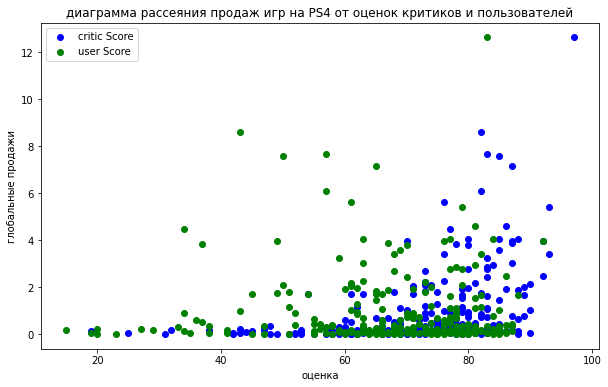

корреляция между оценками критиков и продажами: 0.5078289176410228
корреляция между оценками пользователей и продажами: -0.032430263114838286


In [25]:
ps4_data = data.query(
    'platform == "PS4" and total_sales.notna() and critic_score.notna() and user_score.notna()'
)

plt.figure(figsize=(10, 6))
plt.scatter(ps4_data['critic_score'], ps4_data['total_sales'], color='blue', label='critic Score')
plt.scatter(ps4_data['user_score'], ps4_data['total_sales'], color='green', label='user Score')
plt.title('диаграмма рассеяния продаж игр на PS4 от оценок критиков и пользователей')
plt.xlabel('оценка')
plt.ylabel('глобальные продажи')
plt.legend()
plt.show()

critic_correlation = st.spearmanr(ps4_data['total_sales'].dropna(), ps4_data['critic_score'].dropna()).correlation
user_correlation = st.spearmanr(ps4_data['total_sales'].dropna(), ps4_data['user_score'].dropna()).correlation

print(f"корреляция между оценками критиков и продажами: {critic_correlation}")
print(f"корреляция между оценками пользователей и продажами: {user_correlation}")


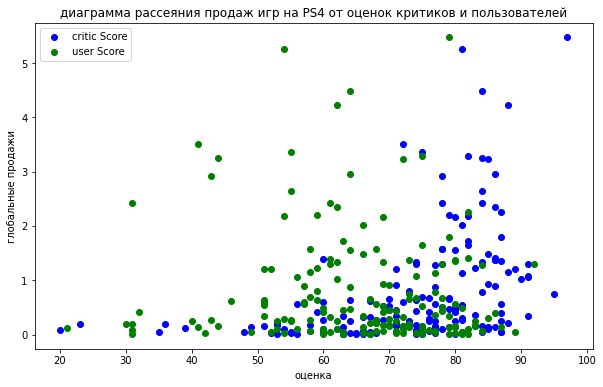

корреляция между оценками критиков и продажами: 0.5162559802537015
корреляция между оценками пользователей и продажами: -0.12204058571597953


In [26]:
ps4_data = data.query(
    'platform == "XOne" and total_sales.notna() and critic_score.notna() and user_score.notna()'
)
plt.figure(figsize=(10, 6))
plt.scatter(ps4_data['critic_score'], ps4_data['total_sales'], color='blue', label='critic Score')
plt.scatter(ps4_data['user_score'], ps4_data['total_sales'], color='green', label='user Score')
plt.title('диаграмма рассеяния продаж игр на PS4 от оценок критиков и пользователей')
plt.xlabel('оценка')
plt.ylabel('глобальные продажи')
plt.legend()
plt.show()

critic_correlation = st.spearmanr(ps4_data['total_sales'].dropna(), ps4_data['critic_score'].dropna()).correlation
user_correlation = st.spearmanr(ps4_data['total_sales'].dropna(), ps4_data['user_score'].dropna()).correlation

print(f"корреляция между оценками критиков и продажами: {critic_correlation}")
print(f"корреляция между оценками пользователей и продажами: {user_correlation}")


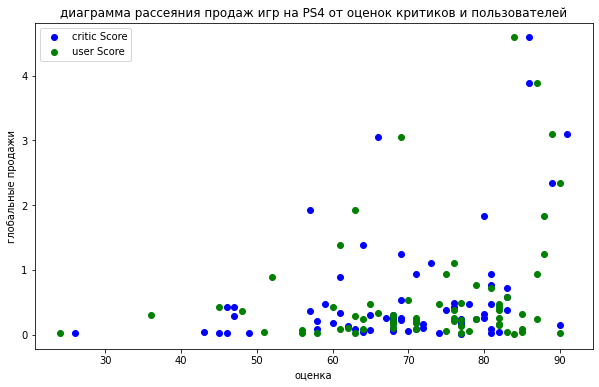

корреляция между оценками критиков и продажами: 0.30885107172796766
корреляция между оценками пользователей и продажами: 0.22025761199450253


In [27]:
ps4_data = data.query(
    'platform == "3DS" and total_sales.notna() and critic_score.notna() and user_score.notna()'
)
plt.figure(figsize=(10, 6))
plt.scatter(ps4_data['critic_score'], ps4_data['total_sales'], color='blue', label='critic Score')
plt.scatter(ps4_data['user_score'], ps4_data['total_sales'], color='green', label='user Score')
plt.title('диаграмма рассеяния продаж игр на PS4 от оценок критиков и пользователей')
plt.xlabel('оценка')
plt.ylabel('глобальные продажи')
plt.legend()
plt.show()

critic_correlation = st.spearmanr(ps4_data['total_sales'].dropna(), ps4_data['critic_score'].dropna()).correlation
user_correlation = st.spearmanr(ps4_data['total_sales'].dropna(), ps4_data['user_score'].dropna()).correlation

print(f"корреляция между оценками критиков и продажами: {critic_correlation}")
print(f"корреляция между оценками пользователей и продажами: {user_correlation}")

судя по графику оценки пользователей корреляции с цифрами продаж не имеют  
оценки критиков имеют средне-слабую корреляцию с количеством продаж  

In [29]:
genre_sales = data.groupby('genre')['total_sales'].agg(['sum', 'count'])
genre_sales['avg_sales_per_game'] = genre_sales['sum'] / genre_sales['count']
genre_sales_sorted = genre_sales['avg_sales_per_game'].sort_values(ascending=False)

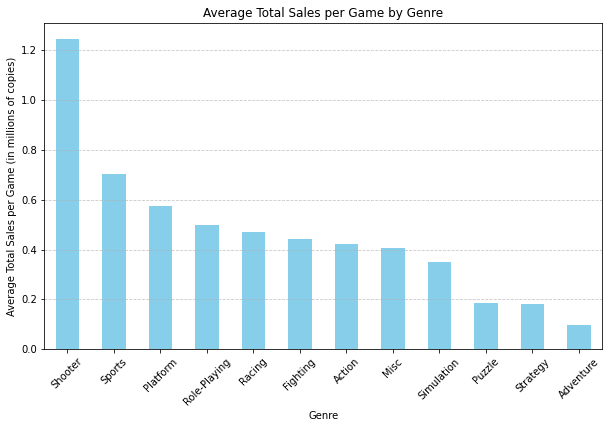

In [30]:
plt.figure(figsize=(10, 6))
genre_sales_sorted.plot(kind='bar', color='skyblue')
plt.title('Average Total Sales per Game by Genre')
plt.xlabel('Genre')
plt.ylabel('Average Total Sales per Game (in millions of copies)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

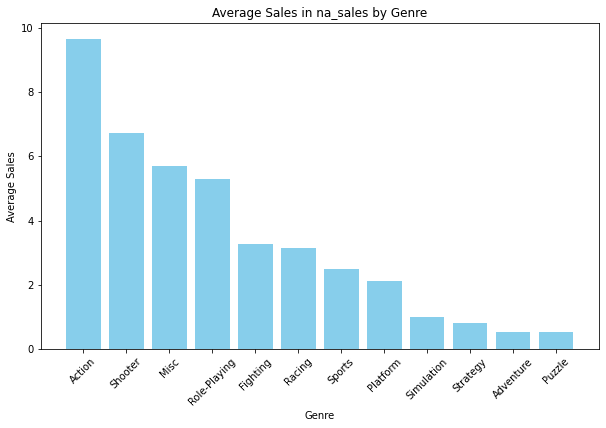

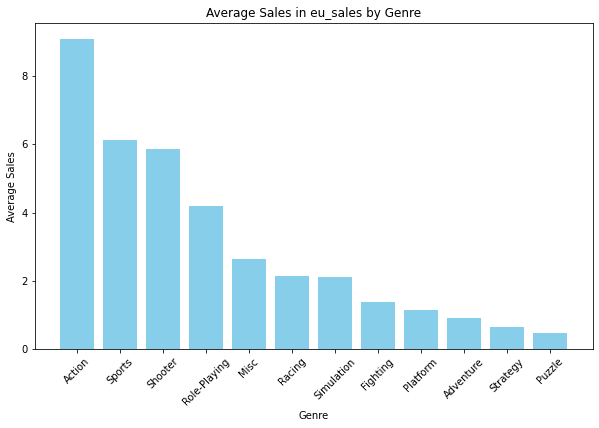

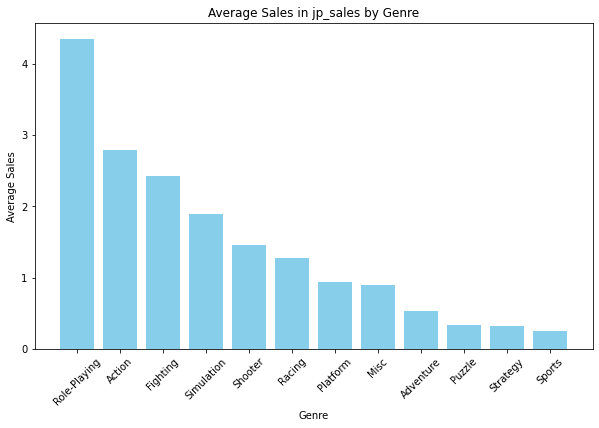

In [31]:
regions = ['na_sales', 'eu_sales', 'jp_sales']

for region in regions:
    plt.figure(figsize=(10, 6))
    sorted_data = data.sort_values(by=region, ascending=False)
    plt.bar(sorted_data['genre'], sorted_data[region], color='skyblue')
    plt.title(f'Average Sales in {region} by Genre')
    plt.xlabel('Genre')
    plt.ylabel('Average Sales')
    plt.xticks(rotation=45)
    plt.show()

In [32]:
print("самые прибыльные жанры:")
print(genre_sales_sorted.head(5))
print("\nнаименее прибыльные жанры:")
print(genre_sales_sorted.tail(5))

самые прибыльные жанры:
genre
Shooter         1.245882
Sports          0.703972
Platform        0.576081
Role-Playing    0.499623
Racing          0.469294
Name: avg_sales_per_game, dtype: float64

наименее прибыльные жанры:
genre
Misc          0.405290
Simulation    0.350968
Puzzle        0.186471
Strategy      0.180000
Adventure     0.096490
Name: avg_sales_per_game, dtype: float64


Явно видно, что самые прибыльные жанры это: platform, shooter, rpg, racing, sports а наименее прибыльные: simulation, misc, puzzle, adventure

## Шаг 4. Портрет пользователя каждого региона

In [33]:
regions = ['na_sales', 'eu_sales', 'jp_sales']
data['rating'] = data['rating'].fillna('No official rating')

platform_sales = data.groupby('platform')[regions].sum()
for region in regions:
    a = platform_sales[[region]].sort_values(by=region, ascending=False).head()
    display(a)

genres = data.groupby('genre')[regions].sum()
for region in regions:
    a = genres[[region]].sort_values(by=region, ascending=False).head()
    display(a)
    
rating = data.groupby('rating')[regions].sum()
for region in regions:
    a = rating[[region]].sort_values(by=region, ascending=False).head()
    display(a)


,na_sales
platform,
PS4,108.74
XOne,93.12
X360,81.66
PS3,63.50
3DS,38.20


,eu_sales
platform,
PS4,141.09
PS3,67.81
XOne,51.59
X360,42.52
3DS,30.96


,jp_sales
platform,
3DS,67.81
PS3,23.35
PSV,18.59
PS4,15.96
WiiU,10.88


,na_sales
genre,
Action,126.05
Shooter,109.74
Sports,65.27
Role-Playing,46.40
Misc,27.49


,eu_sales
genre,
Action,118.13
Shooter,87.86
Sports,60.52
Role-Playing,36.97
Racing,20.19


,jp_sales
genre,
Role-Playing,51.04
Action,40.49
Misc,9.20
Fighting,7.65
Shooter,6.61


,na_sales
rating,
M,165.21
No official rating,89.42
E,79.05
E10+,54.24
T,49.79


,eu_sales
rating,
M,145.32
E,83.36
No official rating,78.91
E10+,42.69
T,41.95


,jp_sales
rating,
No official rating,85.05
T,20.59
E,15.14
M,14.11
E10+,5.89


Видно, что в японии Xbox не пользуется популярностью и самым популярным жанром является рпг  
А рейтинг игр практически не отличается по региноам, в топ 4 везде входят E, без официального рейтинга, M, T, E10+  
Однако в японии с огромным отрывом лидируют игры без рейтинга, либо это ошибка программ, либо в японии диким спросом пользуются мелкие инди игры, либо рейтинг ESRB сложен для получения с бюрократической точки зрения, нежели для западных регионов  

## Шаг 5. Проверка гипотез

Нулевая гипотеза: средняя оценка пользователей игр на ПК и Xbox One одинакова  
Альтернативная гипотеза: средняя оценка отличается

In [34]:
alpha = 0.05
results = st.ttest_ind(
    data.query('platform=="XOne"').dropna()['user_score'],
    data.query('platform=="PC"').dropna()['user_score'], alternative='two-sided'
)
print('pvalue:', results.pvalue)
if results.pvalue < alpha:
    print('отвергаем нулевую гипотезу')
else:
    print('НЕ отвергаем нулевую гипотезу')
    
    
print(
    '\n'
    'Xbox One avg user_score:', data.query('platform=="XOne"')['user_score'].mean(), '\n'
    'PC avg user_score:', data.query('platform=="PC"')['user_score'].mean(),
)

pvalue: 0.17306926618147386
НЕ отвергаем нулевую гипотезу

Xbox One avg user_score: 65.21428571428571 
PC avg user_score: 62.696774193548386


судя по всему средняя оценка игр на ПК и Xbox One одинакова

Нулевая гипотеза: средняя оценка пользователей игр на в жанрах экшн и спорт одинакова  
Альтернативная гипотеза: средняя оценка отличается

In [35]:
alpha = 0.05
results = st.ttest_ind(
    data.query('genre=="Action"').dropna()['user_score'],
    data.query('genre=="Sports"').dropna()['user_score'], alternative='two-sided'
)
print('pvalue:', results.pvalue)
if results.pvalue < alpha:
    print('отвергаем нулевую гипотезу')
else:
    print('НЕ отвергаем нулевую гипотезу')
    
    
print(
    '\n'
    'action avg user_score:', data.query('genre=="Action"')['user_score'].mean(), '\n'
    'sports avg user_score:', data.query('genre=="Sports"')['user_score'].mean(),
)

pvalue: 1.6840994306901232e-16
отвергаем нулевую гипотезу

action avg user_score: 68.37532133676092 
sports avg user_score: 52.38125


судя по всему средняя оценка игр в жанрах экшн больше, нежели жанра спорт

## Шаг 6. Oбщий вывод

Судя по проделанному анализу есть веские доводы разделить рекламные компании по регионам:  

в северной америке стоит уделить внимание на:  
платформы: PS4, Xbox One  
жанры: Action, Shooter, sport  
с рейтингом: М, Е, или без официального рейтинга  

в европейском регионе стоить уделить внимание на:  
платформы: PS4, Xbox One  
жанры: Action, Shooter, sport  
с рейтингом: М, Е, или без официального рейтинга  

в японии стоить уделить внимание на:  
платформы: 3DS, PS4  
жанры: Role play, Action 
с рейтингом: без официального рейтинга, T  

На отзывы пользователей можно не ориентироваться, на отзывы критиков самую малость, но это в крайнем случае

Также хотелось бы посоветовать проверить алгоритмы сбора и хранения данных на баги, так как есть большое количество в пропусках касательно оценок критиков и пользователей